<a href="https://colab.research.google.com/github/sosososoyoen/hh_plus_ai_3/blob/main/work/week1/%EC%8B%AC%ED%99%94_CIFAR10_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 실습

MNIST 모델 심화 연습

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

### CIFAR10 데이터셋 준비

In [ ]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

# 학습용 로더
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
    )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# 테스트용 로더
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
    )
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


### 학습용 이미지 체크

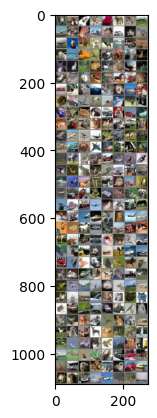

frog  plane ship  deer  truck cat   deer  plane plane truck frog  truck dog   car   dog   bird  plane bird  deer  dog   deer  ship  bird  deer  horse deer  truck bird  cat   frog  cat   deer  cat   cat   deer  frog  deer  cat   plane deer  car   cat   dog   plane deer  horse truck frog  truck bird  dog   plane cat   cat   ship  dog   frog  car   plane horse bird  ship  deer  truck car   frog  cat   cat   car   dog   car   cat   frog  car   cat   horse deer  frog  car   dog   frog  plane bird  plane frog  frog  horse horse horse truck cat   plane deer  truck truck bird  deer  horse bird  horse truck bird  bird  bird  cat   deer  frog  plane cat   truck horse frog  ship  plane deer  bird  horse dog   truck bird  plane car   horse frog  ship  dog   cat   dog   bird  truck car   plane dog   plane truck horse cat   truck plane car   bird  dog   plane plane deer  frog  horse truck frog  dog   frog  cat   horse deer  truck ship  dog   horse plane plane truck deer  truck ship  ship  horse ship

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imgshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 출력
imgshow(torchvision.utils.make_grid(images))

# 정답 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 데이터의 shape 확인

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


4차원 텐서

[0]256 : 배치 사이즈 (한 번에 몇개씩 학습할 것인지)

[1]3 : 채널 수 (컬러이미지 RGB, 흑백은 1)

[2]32 : 이미지 height

[3]32 : 이미지 width


In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

#퍼셉트론 레이어 3개 만들기
    self.layer1 = nn.Linear(input_dim, n_dim) # 입력 -> 은닉층1
    self.layer2 = nn.Linear(n_dim, n_dim) #은닉층1 -> 은닉층2
    self.layer3 = nn.Linear(n_dim, 10) #은닉층2 -> 출력층  10개로 한 이유는 크로스엔트로피 방식의 답변갯수를 고려함 0~9까지

    self.act = nn.LeakyReLU()

#순전파
  def forward(self, x):
    x = torch.flatten(x, start_dim=1) #flatten
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

### SGD & Adam 학습

모델 학습시키는 메서드

In [ ]:
def train_model(trainloader, model, loss_func, optimizer, n_epochs=50):
  loss_history = []
  for epoch in range(n_epochs):
    total_loss = 0.
    for data in trainloader:
      model.zero_grad() #파라미터들의 기울기를 0을 초기화 - 역전파를 통해 기울기를 계산하기 전에!
      # 데이터를 GPU로 보내기
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      # 예측값 계산 (순전파)
      preds = model(inputs)

      loss = loss_func(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    avarage_loss = total_loss / len(trainloader) #한 에폭당 평균 로스값
    loss_history.append(avarage_loss)

    print(f"Epoch {epoch:3d} | Loss: {total_loss}")

  return loss_history # This line was added to return the loss_history

In [ ]:
# 하이퍼 파라미터
n_epochs = 50
input_size = 3 * 32 * 32 #데이터 사이즈
hidden_size = 1024 #은닉층 사이즈.. 1024로 해놓음
lr = 0.001 #학습률

In [ ]:
import torch.optim as optim
# gpu 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 손실함수
loss_func = nn.CrossEntropyLoss()
#Adam 모델
model_adam = Model(input_size, hidden_size).to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr)

adam_loss_history = train_model(trainloader,model_adam,loss_func, optimizer_adam, n_epochs)


Epoch   0 | Loss: 332.7770552635193
Epoch   1 | Loss: 278.2016716003418
Epoch   2 | Loss: 251.69276452064514
Epoch   3 | Loss: 231.34656405448914
Epoch   4 | Loss: 210.2465859055519
Epoch   5 | Loss: 190.90790206193924
Epoch   6 | Loss: 171.13917911052704
Epoch   7 | Loss: 150.86504876613617
Epoch   8 | Loss: 130.80043882131577
Epoch   9 | Loss: 112.77359783649445
Epoch  10 | Loss: 97.59713405370712
Epoch  11 | Loss: 82.8184614777565
Epoch  12 | Loss: 70.45005947351456
Epoch  13 | Loss: 59.36648413538933
Epoch  14 | Loss: 52.7456563860178
Epoch  15 | Loss: 49.79617317020893
Epoch  16 | Loss: 41.81150455772877
Epoch  17 | Loss: 43.29406862705946
Epoch  18 | Loss: 34.700750544667244
Epoch  19 | Loss: 33.58860933035612
Epoch  20 | Loss: 35.43116795271635
Epoch  21 | Loss: 39.20407077670097
Epoch  22 | Loss: 31.157451458275318
Epoch  23 | Loss: 26.572607297450304
Epoch  24 | Loss: 25.980731170624495
Epoch  25 | Loss: 29.54065664112568
Epoch  26 | Loss: 31.113327283412218
Epoch  27 | Loss: 

In [ ]:
from torch.optim import SGD
# gpu 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 손실함수
loss_func = nn.CrossEntropyLoss()

#SGD
model_sgd = Model(input_size, hidden_size).to(device)
optimizer_sgd = SGD(model_sgd.parameters(), lr=lr)
sgd_loss_history = train_model(trainloader,model_sgd,loss_func, optimizer_sgd, n_epochs)

Epoch   0 | Loss: 450.35960149765015
Epoch   1 | Loss: 447.9993941783905
Epoch   2 | Loss: 445.29722261428833
Epoch   3 | Loss: 442.43307852745056
Epoch   4 | Loss: 439.47076773643494
Epoch   5 | Loss: 436.4688787460327
Epoch   6 | Loss: 433.38565015792847
Epoch   7 | Loss: 430.2172417640686
Epoch   8 | Loss: 427.02580547332764
Epoch   9 | Loss: 423.8234279155731
Epoch  10 | Loss: 420.71869587898254
Epoch  11 | Loss: 417.62053060531616
Epoch  12 | Loss: 414.5253994464874
Epoch  13 | Loss: 411.63590908050537
Epoch  14 | Loss: 408.6546297073364
Epoch  15 | Loss: 405.7969971895218
Epoch  16 | Loss: 403.05743849277496
Epoch  17 | Loss: 400.35820758342743
Epoch  18 | Loss: 397.72820472717285
Epoch  19 | Loss: 395.122656583786
Epoch  20 | Loss: 392.6654706001282
Epoch  21 | Loss: 390.27441906929016
Epoch  22 | Loss: 387.7935575246811
Epoch  23 | Loss: 385.590300321579
Epoch  24 | Loss: 383.39049780368805
Epoch  25 | Loss: 381.1938302516937
Epoch  26 | Loss: 379.0797721147537
Epoch  27 | Loss

### ADAM과 SGD 비교

plot 그려주는 함수

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_acc(train_accs, test_accs, label1='train', label2='test', epochs=50):
  x = np.arange(epochs)

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.title('avarage loss comparison')
  plt.xlabel('epoch')
  plt.ylabel('avarage loss')
  plt.legend()
  plt.show()


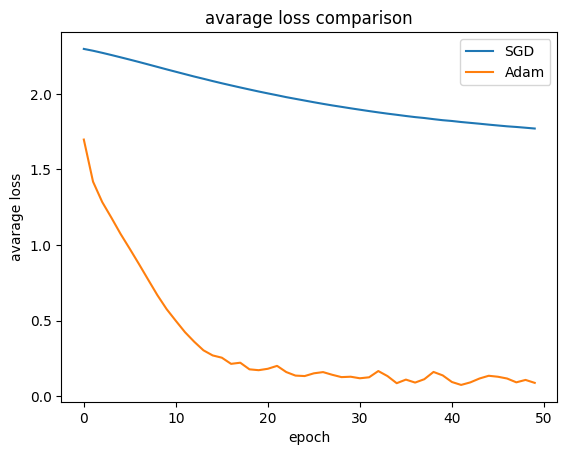

In [ ]:
plot_acc(sgd_loss_history, adam_loss_history, 'SGD', 'Adam', n_epochs)

In [ ]:
print(adam_loss_history)

[1.6600298918023402, 1.4104124064348182, 1.282256233448885, 1.1777673938444682, 1.0695745853745207, 0.9702308816569192, 0.864411078545512, 0.7702767523575802, 0.6697968618602169, 0.5757604980347107, 0.4880697556904384, 0.4158565731985228, 0.3481384492954429, 0.306973079561579, 0.28650036705087645, 0.2596959538605748, 0.22662888216424962, 0.20151610653467325, 0.21144393443757173, 0.18000749684870243, 0.16800988089217214, 0.16878833100959964, 0.14124556201301058, 0.16462068362351584, 0.17206593637107587, 0.1608913665143203, 0.1499746625254653, 0.1412977532920789, 0.11550670253987215, 0.13107174452470274, 0.1302336442417332, 0.1302339351374884, 0.14346918106383208, 0.12361498538176624, 0.11868755675244089, 0.1139191101704325, 0.12462323814706534, 0.13430337011053853, 0.13083664964580413, 0.12434171744603284, 0.1127109166082679, 0.08743621944925006, 0.12745189090848577, 0.11598210483409312, 0.1060748605475742, 0.09670464483526897, 0.09025722530157286, 0.11963288049802792, 0.123854247320975

### ReLU vs Sigmoid

시그모이드 사용한 모델 정의

In [ ]:
from torch import nn


class Model_Sigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

#퍼셉트론 레이어 3개 만들기
    self.layer1 = nn.Linear(input_dim, n_dim) # 입력 -> 은닉층1
    self.layer2 = nn.Linear(n_dim, n_dim) #은닉층1 -> 은닉층2
    self.layer3 = nn.Linear(n_dim, 10) #은닉층2 -> 출력층  10개로 한 이유는 크로스엔트로피 방식의 답변갯수를 고려함 0~9까지

    self.act = nn.Sigmoid()

#순전파
  def forward(self, x):
    x = torch.flatten(x, start_dim=1) #flatten
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

모델 학습

In [ ]:
#Adam + sigmoid
model_adam_sigmoid = Model_Sigmoid(input_size, hidden_size).to(device)
optimizer_adam = optim.Adam(model_adam_sigmoid.parameters(), lr=lr)

adam_sigmoid_loss_history = train_model(trainloader,model_adam_sigmoid,loss_func, optimizer_adam, n_epochs)

Epoch   0 | Loss: 399.8389365673065
Epoch   1 | Loss: 383.33901476860046
Epoch   2 | Loss: 377.33023142814636
Epoch   3 | Loss: 372.30716383457184
Epoch   4 | Loss: 368.17463767528534
Epoch   5 | Loss: 364.1822190284729
Epoch   6 | Loss: 360.59131050109863
Epoch   7 | Loss: 357.68986344337463
Epoch   8 | Loss: 354.23866522312164
Epoch   9 | Loss: 350.7973405122757
Epoch  10 | Loss: 348.4178307056427
Epoch  11 | Loss: 345.6667814254761
Epoch  12 | Loss: 343.0922565460205
Epoch  13 | Loss: 340.79729616642
Epoch  14 | Loss: 338.5472654104233
Epoch  15 | Loss: 336.85483825206757
Epoch  16 | Loss: 334.96514987945557
Epoch  17 | Loss: 333.11132860183716
Epoch  18 | Loss: 331.0329033136368
Epoch  19 | Loss: 329.91066014766693
Epoch  20 | Loss: 328.2543647289276
Epoch  21 | Loss: 327.32353687286377
Epoch  22 | Loss: 326.09939336776733
Epoch  23 | Loss: 324.7911537885666
Epoch  24 | Loss: 324.08649611473083
Epoch  25 | Loss: 323.3230822086334
Epoch  26 | Loss: 322.1187287569046
Epoch  27 | Loss

plot으로 그리기

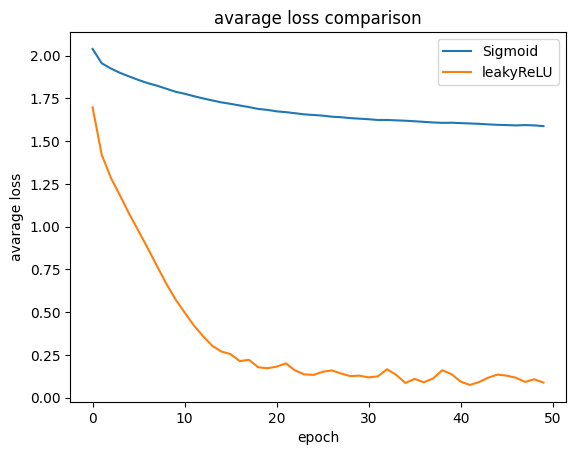

In [ ]:
plot_acc(adam_sigmoid_loss_history, adam_loss_history, 'Sigmoid', 'leakyReLU', n_epochs)

### dropout 적용

In [ ]:
def accuracy(model, dataloader):
  cnt = 0 #카운트. 전체 데이터 개수
  acc = 0 #정확도. 정확히 예측한 개수

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #예측값 중에서 가장 높은 값의 인덱스 찾기
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

dropout이 적용된 모델 정의

In [ ]:
from torch import nn


class Model_dropout(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

#퍼셉트론 레이어 3개 만들기
    self.layer1 = nn.Linear(input_dim, n_dim) # 입력 -> 은닉층1
    self.layer2 = nn.Linear(n_dim, n_dim) #은닉층1 -> 은닉층2
    self.layer3 = nn.Linear(n_dim, 10) #은닉층2 -> 출력층  10개로 한 이유는 크로스엔트로피 방식의 답변갯수를 고려함 0~9까지

    self.act = nn.LeakyReLU()

    self.dropout = nn.Dropout(p=0.1)

#순전파
  def forward(self, x):
    x = torch.flatten(x, start_dim=1) #flatten
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x

학습 및 평가

In [ ]:
model_dropout = Model_dropout(32 * 32 * 3, 1024).to(device)

train_dropout = []
test_dropout = []

for epoch in range(n_epochs):
  total_loss = 0
  model_dropout.train()  # dropout 활성화 (뉴런 무작위 드롭)
  for data in trainloader:
    model_dropout.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_dropout(inputs)
    loss = loss_func(preds, labels)
    loss.backward()
    optimizer_adam.step()

    total_loss += loss.item()

  with torch.no_grad():  # 정확도 계산
    model_dropout.eval() # dropout 비활성화 (모든 뉴런 사용)
    train_dropout.append(accuracy(model_dropout, trainloader))
    test_dropout.append(accuracy(model_dropout, testloader))

  print(f"Epoch {epoch + 1:3d} | Loss: {total_loss}")

Epoch   1 | Loss: 451.39498138427734
Epoch   2 | Loss: 451.40075063705444
Epoch   3 | Loss: 451.38981008529663
Epoch   4 | Loss: 451.3609986305237
Epoch   5 | Loss: 451.4239137172699
Epoch   6 | Loss: 451.3881199359894
Epoch   7 | Loss: 451.39824867248535
Epoch   8 | Loss: 451.41103506088257
Epoch   9 | Loss: 451.40564155578613
Epoch  10 | Loss: 451.4513590335846
Epoch  11 | Loss: 451.43056201934814


KeyboardInterrupt: 

GPU를 다 써서 에폭 10번까지밖에 학습을 못했습니다ㅠㅠ

정확도를 그래프로 확인

In [ ]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

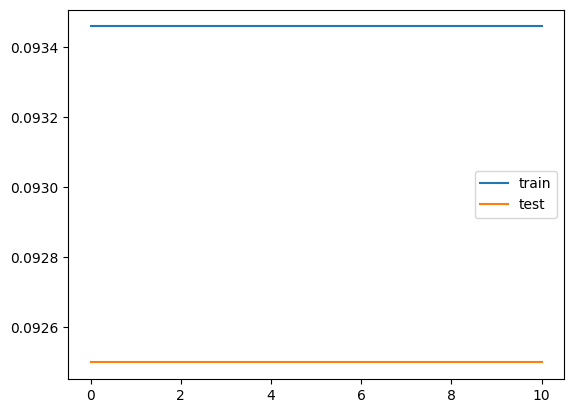

In [ ]:
plot_acc(train_dropout, test_dropout)

In [ ]:
# 예측과 정답을 비교하는 함수
def compare_prediction(model, dataset, idx):

    # 드롭아웃 비활성화
    model.eval()

    # 이미지와 라벨 가져오기
    image, label = dataset[idx]

    # 이미지 모델 입력 형태로 변환
    x = image.unsqueeze(0).to('cuda')
    #(3,32,32) -> unsqueeze(0번째 위치에 새로운 차원 추가) -> (1, 3, 32, 32) (배치 크기, 채널 수 , 높이, 너비)

    # 모델 예측값 계산
    with torch.no_grad():  # 기울기 계산 비활성화
        output = model(x)

    # 예측값(가장 높은 값의 인덱스) 얻기
    predict_class = torch.argmax(output)

    # 예측값과 정답 출력
    print("예측값:", predict_class.item(), "-", classes[predict_class.item()])
    print("정답:", label, "-", classes[label])

    # 이미지 출력하기
    plt.imshow(image.permute(1, 2, 0))  # 이미지의 차원 순서를 바꿔서 표시 (C, H, W) -> (H, W, C)
    plt.title(f"predict : {classes[predict_class.item()]} | answer: {classes[label]}")
    plt.axis('off')
    plt.show()

예측값: 5 - dog
정답: 8 - ship


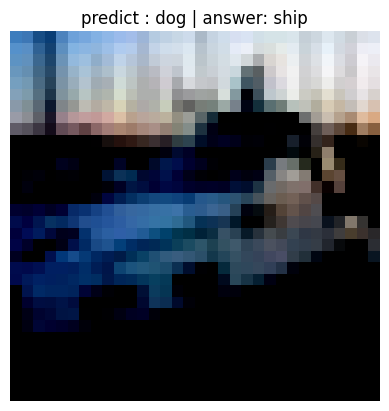

In [ ]:
idx = 2  # 확인하고 싶은 데이터의 인덱스
compare_prediction(model_dropout, testset, idx)

예측값: 9 - truck
정답: 9 - truck


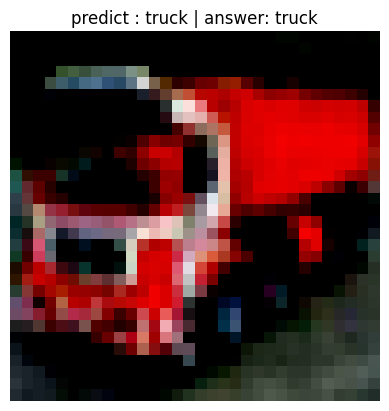

In [ ]:
idx = 666  # 확인하고 싶은 데이터의 인덱스
compare_prediction(model_adam, testset, idx)